In [4]:
import re
import os
import sys
import logging
import ast

import polars as pl

from sklearn.metrics import (confusion_matrix, roc_curve, roc_auc_score, precision_recall_curve, r2_score, 
								mean_squared_error, mean_absolute_error, accuracy_score, f1_score, median_absolute_error)
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import seaborn as sns
import xgboost as xgb
from xgboost import XGBRegressor, XGBClassifier

import optuna
from optuna.samplers import TPESampler


import os
import re
from pathlib import Path
from typing import Union, Tuple, List, Optional
from collections.abc import Callable


sys.path.append(os.path.abspath(os.path.join(os.getcwd(), '..')))

from utils.modelling.data import *
from utils.modelling.evaluation import *
from utils.modelling.training import *
from utils.modelling.tuning import *

# Training Retention Model

### Import Dataset

In [ ]:
df = pl.read_parquet('/kaggle/input/eda-dataset/preprocessed_data.parquet')
df

session_id,user_id_first,device_family_linux_max,device_family_mac os x_max,device_family_windows_max,region_grouped_international_max,region_grouped_midwest_max,region_grouped_northeast_max,region_grouped_south_max,region_grouped_west_max,event_category_account & policy management_max,event_category_action center & workflow_max,event_category_dashboard & ui interactions_max,event_category_other/system events_max,event_category_session & navigation_max,event_category_submission & forms_max,returned_within_28_days_max,uw_max,admin_max,manager_max,broker_max,google_max,microsoft_max,session_seconds_mean,client_event_hour_mean,client_upload_hour_mean,event_hour_mean,server_received_hour_mean,server_upload_hour_mean,time_to_server_mean,server_to_process_mean,processing_time_mean,slug_encoded_mean
i64,str,u8,u8,u8,u8,u8,u8,u8,u8,u8,u8,u8,u8,u8,u8,i32,i8,i8,i8,i8,i32,i32,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64
1738009295198,"""acb60a19-d8c0-4924-88c8-78ccda…",0,0,1,0,0,1,0,0,1,0,0,0,1,0,0,1,0,0,0,0,0,937.0,20.0,19.851852,20.0,19.851852,19.851852,1076.148148,0.0,3.592593,0.044815
1735916130662,"""6cd4ff43-3226-4bbf-8203-5d0147…",0,1,0,0,0,0,1,0,1,0,0,0,1,0,0,1,0,0,0,0,0,0.0,14.0,14.5,14.0,14.5,14.5,1598.75,0.0,1.5,0.045
1714423842058,"""bbf4e34e-e76a-46e3-a5c4-cfa9c5…",0,0,1,0,0,0,1,0,0,1,0,0,1,0,0,1,0,0,0,0,0,16.0,20.0,20.0,20.0,20.0,20.0,2.0,0.0,0.6,0.0
1722269362779,"""94c518d5-37d3-4c2d-8c2b-72e9fb…",0,0,1,0,1,0,0,0,0,0,0,0,1,0,0,1,0,0,0,0,0,0.0,16.0,16.0,16.0,16.0,16.0,1.0,0.0,0.0,0.0
1696438324976,"""f8494058-23b9-466c-a10b-f201a1…",0,0,1,0,0,1,0,0,1,0,0,0,1,0,0,1,0,0,0,0,0,6.0,16.0,17.0,16.0,17.0,17.0,1.4778e7,0.0,10.0,0.0
…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…
1715645444982,"""afe99d2f-4fce-4584-a360-967b87…",1,0,0,0,0,0,0,1,0,0,0,0,1,0,0,1,0,0,0,0,0,1.0,0.0,0.0,0.0,0.0,0.0,1.5,0.0,2.0,0.0
1711108354862,"""f0457050-c716-4f31-8755-f256a9…",0,0,1,0,0,0,1,0,1,0,0,0,1,0,0,1,0,0,0,0,0,551.0,11.25,1.0,11.25,1.0,1.0,827437.75,0.0,150.75,0.0
1726687903267,"""cd3715bf-0c84-41f2-aa54-345093…",0,0,1,0,0,0,1,0,0,0,0,0,1,0,0,1,0,0,0,0,0,33.0,19.0,18.666667,19.0,18.666667,18.666667,3671.0,0.0,1.0,0.02


In [143]:
df = df.with_columns(
 pl.col('user_id_first').map_elements(lambda x: x[-1], return_dtype=pl.String).alias('train')
) 

In [144]:
df['train'].value_counts().with_columns(
    pl.col('count').map_elements(lambda x: x/df.shape[0])
)

<ipython-input-144-e72ca0130cb4>:1: MapWithoutReturnDtypeWarning: Calling `map_elements` without specifying `return_dtype` can lead to unpredictable results. Specify `return_dtype` to silence this warning.
  df['train'].value_counts().with_columns(


train,count
str,f64
"""f""",0.065342
"""2""",0.107407
"""m""",0.000005
"""0""",0.10762
"""5""",0.057113
…,…
"""3""",0.032068
"""c""",0.055647
"""1""",0.071528


In [145]:

df = df.drop(["session_id", "user_id_first"])

In [146]:
df_test = df.filter((pl.col('train') == '5') | (pl.col('train') == '6'))

In [147]:
df_val = df.filter((pl.col('train') == "0") )

In [148]:
df_train = df.filter((pl.col('train') != '5') & (pl.col('train') != '6') & (pl.col('train') != '0') )

### Add random column

In [151]:
import numpy as np
df = df.with_columns(pl.Series("random_col", np.random.rand(df.shape[0])))

In [152]:
df

device_family_linux_max,device_family_mac os x_max,device_family_windows_max,region_grouped_international_max,region_grouped_midwest_max,region_grouped_northeast_max,region_grouped_south_max,region_grouped_west_max,event_category_account & policy management_max,event_category_action center & workflow_max,event_category_dashboard & ui interactions_max,event_category_other/system events_max,event_category_session & navigation_max,event_category_submission & forms_max,returned_within_28_days_max,uw_max,admin_max,manager_max,broker_max,google_max,microsoft_max,session_seconds_mean,client_event_hour_mean,client_upload_hour_mean,event_hour_mean,server_received_hour_mean,server_upload_hour_mean,time_to_server_mean,server_to_process_mean,processing_time_mean,slug_encoded_mean,train,random_col
u8,u8,u8,u8,u8,u8,u8,u8,u8,u8,u8,u8,u8,u8,i32,i8,i8,i8,i8,i32,i32,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,str,f64
0,0,1,0,0,1,0,0,1,0,0,0,1,0,0,1,0,0,0,0,0,937.0,20.0,19.851852,20.0,19.851852,19.851852,1076.148148,0.0,3.592593,0.044815,"""7""",0.776225
0,1,0,0,0,0,1,0,1,0,0,0,1,0,0,1,0,0,0,0,0,0.0,14.0,14.5,14.0,14.5,14.5,1598.75,0.0,1.5,0.045,"""d""",0.109178
0,0,1,0,0,0,1,0,0,1,0,0,1,0,0,1,0,0,0,0,0,16.0,20.0,20.0,20.0,20.0,20.0,2.0,0.0,0.6,0.0,"""0""",0.325954
0,0,1,0,1,0,0,0,0,0,0,0,1,0,0,1,0,0,0,0,0,0.0,16.0,16.0,16.0,16.0,16.0,1.0,0.0,0.0,0.0,"""0""",0.528605
0,0,1,0,0,1,0,0,1,0,0,0,1,0,0,1,0,0,0,0,0,6.0,16.0,17.0,16.0,17.0,17.0,1.4778e7,0.0,10.0,0.0,"""f""",0.445258
…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…
1,0,0,0,0,0,0,1,0,0,0,0,1,0,0,1,0,0,0,0,0,1.0,0.0,0.0,0.0,0.0,0.0,1.5,0.0,2.0,0.0,"""2""",0.406242
0,0,1,0,0,0,1,0,1,0,0,0,1,0,0,1,0,0,0,0,0,551.0,11.25,1.0,11.25,1.0,1.0,827437.75,0.0,150.75,0.0,"""8""",0.229212
0,0,1,0,0,0,1,0,0,0,0,0,1,0,0,1,0,0,0,0,0,33.0,19.0,18.666667,19.0,18.666667,18.666667,3671.0,0.0,1.0,0.02,"""d""",0.608756


### Run Preprocessing Pipeline

In [6]:
def preprocess_retention_data(df):
    return df

In [7]:
# Preprocess data
df = preprocess_retention_data(df)

# Training

### Data Split

In [6]:
# Split data into train, validation and test sets
train_validation_split = TrainValidationSplit(val_ratio = 0.01, random_state = 42)
time_split = TimeSplit('2025-01-01')

In [153]:
# # Split df to training, validation, and test sets
# df_test, df_leftover = time_split.data_split(df, 'event_time_max')

# df_train, df_val = train_validation_split.data_split(df_leftover)

# df_train = df_train.drop(["session_id", "user_id_first", "train"])
# df_val = df_val.drop(["session_id", "user_id_first", "train"])
# df_test = df_test.drop(["session_id", "user_id_first", "train"])

# Split each set into relevant X and y data
X_train, y_train = train_validation_split.X_y_split(df_train, 'returned_within_28_days_max')
X_val, y_val = train_validation_split.X_y_split(df_val, 'returned_within_28_days_max')
X_test, y_test = time_split.X_y_split(df_test, 'returned_within_28_days_max')



# Clean data function
def clean_data(X, y):
    mask = ~(y.is_null() | y.is_infinite())
    X = X.drop('train')
    return X.filter(mask), y.filter(mask)

# Apply cleaning to pre-split data
X_train, y_train = clean_data(X_train, y_train)
X_val, y_val = clean_data(X_val, y_val)
X_test, y_test = clean_data(X_test, y_test)

In [154]:
df['returned_within_28_days_max'].mean()

0.05974835965102026

### Initialize Trainer

In [155]:
# Initialize trainer and dataloader
dataloader = Dataloader(batch_size = 500000)
trainer = Trainer(XGBClassifier, dataloader)


# Specify model parameters
params = {'eval_set' : [(X_train, y_train), (X_val, y_val)]}

### Train Model

In [156]:
# Train the model
model = trainer.fit_batch(X_train, y_train, params)

hheloo
????


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:160: UserWarning: [08:56:15] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "eval_set" } are not used.

  warnings.warn(smsg, UserWarning)


# Evaluation

In [157]:
params = {
    'objective': 'binary:logistic',
    'eval_metric': 'logloss',
    'random_state': 42
}

# Train initial model
model = trainer.fit_batch(X_train, y_train, params)

# Add evaluation sets for learning curve
eval_set = [(X_train, y_train), (X_val, y_val)]
model.fit(X_train, y_train, eval_set=eval_set, verbose=False)


XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric='logloss',
              feature_types=None, gamma=None, grow_policy=None,
              importance_type=None, interaction_constraints=None,
              learning_rate=None, max_bin=None, max_cat_threshold=None,
              max_cat_to_onehot=None, max_delta_step=None, max_depth=None,
              max_leaves=None, min_child_weight=None, missing=nan,
              monotone_constraints=None, multi_strategy=None, n_estimators=None,
              n_jobs=None, num_parallel_tree=None, random_state=42, ...)

In [158]:
eval_classifier = ClassificationEvaluation(model)

Validation Set Metrics:
Accuracy:
0.9638376630990068
F1:
0.1898686679174484
AUC:
0.9111074926700788
Confusion Matrix:
[[57291   220]
 [ 1939   253]]

Test Set Metrics:
Accuracy:
0.9311262287507767
F1:
0.20983366843355877
AUC:
0.8286033270314241
Confusion Matrix:
[[57870   406]
 [ 3917   574]]

Plotting ROC Curve for Test Set:


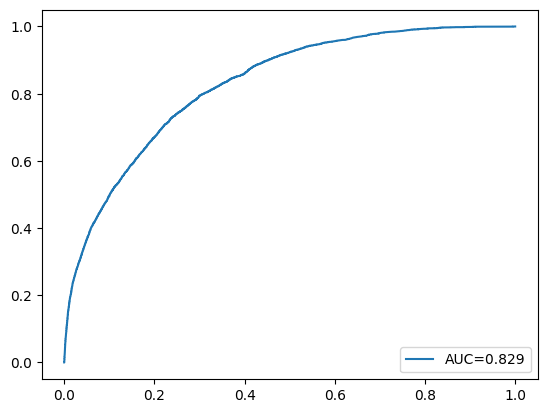

Plotting Learning Curve:


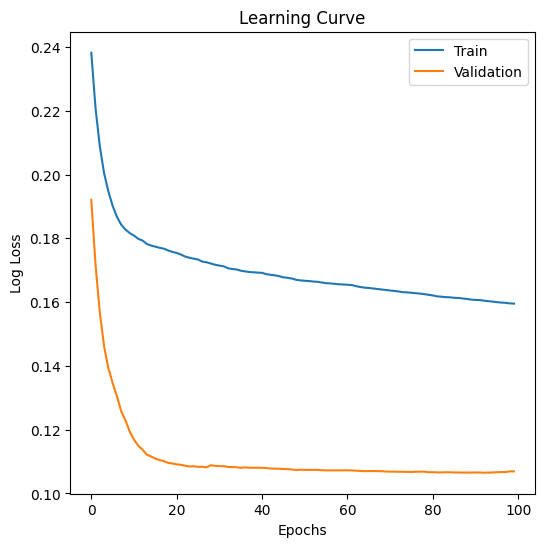

Plotting Feature Importance:


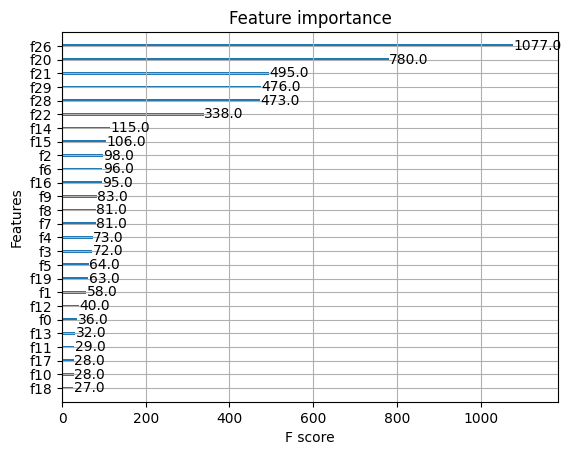

<Axes: title={'center': 'Feature importance'}, xlabel='F score', ylabel='Features'>

In [159]:
print("Validation Set Metrics:")
eval_classifier.get_classification_metrics(X_val, y_val)

print("\nTest Set Metrics:")
eval_classifier.get_classification_metrics(X_test, y_test)

print("\nPlotting ROC Curve for Test Set:")
eval_classifier.plot_roc_curve(X_test, y_test)

print("Plotting Learning Curve:")
eval_classifier.plot_learning_curve()

print("Plotting Feature Importance:")
eval_classifier.plot_feature_importance(X_test, y_test)

# Optimization

In [16]:
from sklearn.metrics import log_loss
df_test, df_leftover = time_split.data_split(df, "event_time_max")  # Test split
df_train, df_val = train_validation_split.data_split(df_leftover)

# === Extract Features and Target ===
target_col = "returned_within_7_days_max"

X_train, y_train = train_validation_split.X_y_split(df_train, target_col)
X_val, y_val = train_validation_split.X_y_split(df_val, target_col)
X_test, y_test = time_split.X_y_split(df_test, target_col)

# === Convert Polars DataFrames to NumPy (XGBoost requires NumPy arrays) ===
X_train, y_train = X_train, y_train
X_val, y_val = X_val, y_val
X_test, y_test = X_test, y_test

# Apply cleaning to pre-split data
X_train, y_train = clean_data(X_train, y_train)
X_val, y_val = clean_data(X_val, y_val)
X_test, y_test = clean_data(X_test, y_test)

# Define Objective Function for Optuna
def objective(trial):
    params = {
        "max_depth": trial.suggest_int("max_depth", 3, 10),
        "learning_rate": trial.suggest_float("learning_rate", 0.01, 0.3),
        "n_estimators": trial.suggest_int("n_estimators", 50, 500),
        "min_child_weight": trial.suggest_int("min_child_weight", 1, 10),
        "subsample": trial.suggest_float("subsample", 0.5, 1.0),
        "colsample_bytree": trial.suggest_float("colsample_bytree", 0.5, 1.0),
        "gamma": trial.suggest_float("gamma", 0, 5),
        "lambda": trial.suggest_float("lambda", 0, 5),
        "alpha": trial.suggest_float("alpha", 0, 5),
        "objective": "binary:logistic",  
        "eval_metric": "logloss", 
        "random_state": 42,
        "use_label_encoder": False
    }

    # Train Model
    model = xgb.XGBClassifier(**params)
    model.fit(
        X_train, y_train,
        eval_set=[(X_val, y_val)],
        verbose=False,
        early_stopping_rounds=10
    )

    # Predict Probabilities
    y_pred_proba = model.predict_proba(X_val)[:, 1]

    # Compute Log Loss (Minimization Objective)
    return log_loss(y_val, y_pred_proba)

# Run Optuna Optimization
study = optuna.create_study(direction="minimize")  # We minimize log loss
study.optimize(objective, n_trials=20)  # Adjust the number of trials for better results

# Print Best Parameters
print("Best Hyperparameters:", study.best_params)


[I 2025-02-24 06:22:50,711] A new study created in memory with name: no-name-8bd7d440-889a-4c27-a216-1416b278f7a9
[I 2025-02-24 06:22:52,514] Trial 0 finished with value: 0.29891732612381966 and parameters: {'max_depth': 6, 'learning_rate': 0.17341438717923657, 'n_estimators': 261, 'min_child_weight': 1, 'subsample': 0.6780580480841936, 'colsample_bytree': 0.6354044885749961, 'gamma': 2.9581000781734836, 'lambda': 3.1672752506558184, 'alpha': 2.595827246585882}. Best is trial 0 with value: 0.29891732612381966.
/usr/local/lib/python3.10/dist-packages/xgboost/sklearn.py:889: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(
[I 2025-02-24 06:22:54,379] Trial 1 finished with value: 0.2970902470435984 and parameters: {'max_depth': 7, 'learning_rate': 0.17282029481791802, 'n_estimators': 498, 'min_child_weight': 6, 'subsample': 0.6857246499774197, '

Best Hyperparameters: {'max_depth': 9, 'learning_rate': 0.1359583834286745, 'n_estimators': 289, 'min_child_weight': 10, 'subsample': 0.6145220547520995, 'colsample_bytree': 0.7929106672318951, 'gamma': 0.7411544836729926, 'lambda': 2.9960474762550495, 'alpha': 3.130647936175933}


In [163]:
# Train Final Model with Best Parameters
best_params = study.best_params
final_model = xgb.XGBClassifier(**best_params)
eval_set = [(X_train, y_train), (X_val, y_val)]
final_model.fit(X_train, y_train, eval_set=eval_set, verbose=False)

# Make Predictions on Test Set
y_test_pred = final_model.predict(X_test)
y_test_pred_proba = final_model.predict_proba(X_test)[:, 1]

# Evaluate Model Performance
accuracy = accuracy_score(y_test, y_test_pred)
logloss = log_loss(y_test, y_test_pred_proba)
auc = roc_auc_score(y_test, y_test_pred_proba)

print(f"Final Model Accuracy: {accuracy:.4f}")
print(f"Final Log Loss: {logloss:.4f}")
print(f"Final AUC Score: {auc:.4f}")

Final Model Accuracy: 0.9319
Final Log Loss: 0.2043
Final AUC Score: 0.8273


Validation Set Metrics:
Accuracy:
0.9634524228263236
F1:
0.20769789397240376
AUC:
0.9097137534273037
Confusion Matrix:
[[57235   276]
 [ 1906   286]]

Test Set Metrics:
Accuracy:
0.9318909618111428
F1:
0.2254031527450625
AUC:
0.8273042584585741
Confusion Matrix:
[[57870   406]
 [ 3869   622]]

Plotting ROC Curve for Test Set:


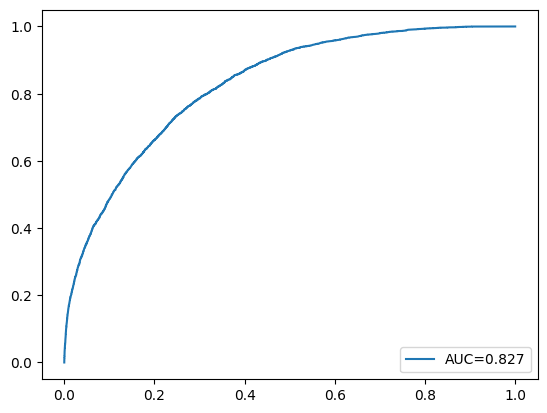

Plotting Learning Curve:


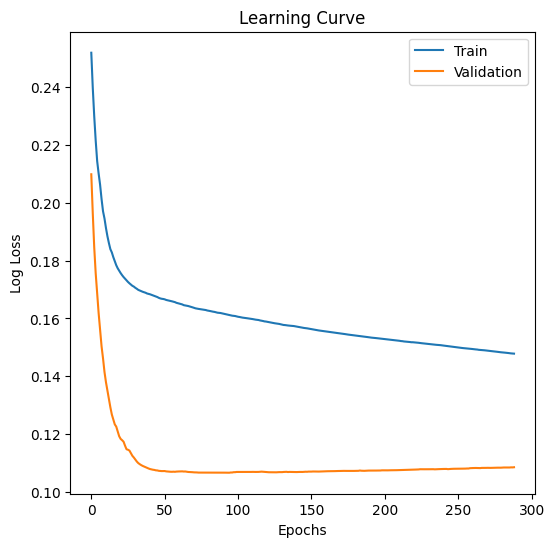

Plotting Feature Importance:


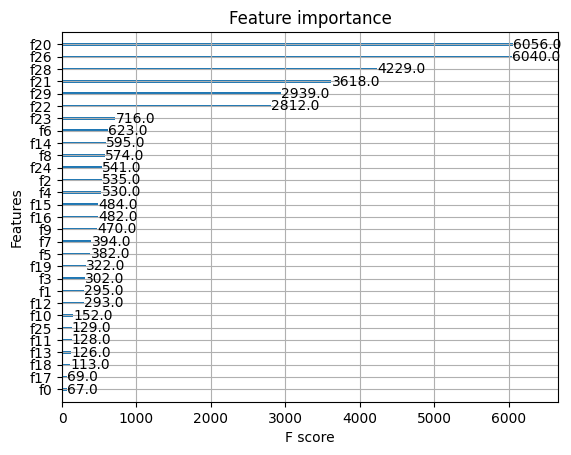

<Axes: title={'center': 'Feature importance'}, xlabel='F score', ylabel='Features'>

In [164]:
eval_classifier = ClassificationEvaluation(final_model)

print("Validation Set Metrics:")
eval_classifier.get_classification_metrics(X_val, y_val)

print("\nTest Set Metrics:")
eval_classifier.get_classification_metrics(X_test, y_test)

print("\nPlotting ROC Curve for Test Set:")
eval_classifier.plot_roc_curve(X_test, y_test)

print("Plotting Learning Curve:")
eval_classifier.plot_learning_curve()

print("Plotting Feature Importance:")
eval_classifier.plot_feature_importance(X_test, y_test)

In [161]:
import pickle

# Define the filename for saving the model
model_filename = "xgb_classifier.pkl"

# Save the model using pickle
with open(model_filename, "wb") as file:
    pickle.dump(final_model, file)

print(f"Model saved successfully as {model_filename}")


Model saved successfully as xgb_classifier.pkl
